# Denoising scRNA-seq using DCA

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.api as sc
import DCA.api as dca

Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


Using TensorFlow backend.


In [195]:
import pandas as pd

## scRNA-seq Simulation using Splatter R package and rpy2

In [60]:
%config InlineBackend.figure_format = 'retina'

In [61]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)

mpl.rcParams['savefig.dpi'] = 300

In [3]:
import sys
print(sys.executable)

/home/alabarga/NavarraBiomed/tesis/.tesis-env/bin/python3


In [4]:
from rpy2 import robjects
robjects.r("version")


R object with classes: ('simple.list',) mapped to:
<ListVector - Python:0x7f3e07fc9248 / R:0x3a13098>
[StrVector, StrVector, StrVector, StrVector, ..., StrVector, StrVector, StrVector, StrVector]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f3e07f7da88 / R:0x3a28fc8>
['x86_64-pc-linux-gnu']
  arch: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f3e07f7dd48 / R:0x3a28f58>
['x86_64']
  os: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f3e07f7df88 / R:0x3a28eb0>
['linux-gnu']
  system: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f3e07f80248 / R:0x3a28e78>
['x86_64, linux-gnu']
...
  major: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f3e07f804c8 / R:0x3a28a50>
['74626']
  minor: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f3e07f80748 / R:0x3a289e0>
['R']
  year: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f3e07f7dfc8 / R:0x3a289a8>
['R version 3.5.0 (2018-04-23)']
  month: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f3e07f7db88 / R:0x3a28970>
['Joy in Playing']

In [5]:
from rpy2.rinterface import R_VERSION_BUILD
print(R_VERSION_BUILD)

('3', '4.4', '', 74408)


In [6]:
%load_ext rpy2.ipython

In [7]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

### Simulate two groups using Splatter

In [69]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups
    sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells, method=method, 
                          seed=42, dropout.type="experiment", dropout.mid=dropout, dropout.shape=-1)

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate(nGroups=2, nGenes=200, batchCells=2000, dropout=5)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

/home/alabarga/NavarraBiomed/tesis/.tesis-env/lib/python3.5/site-packages/rpy2-2.9.4-py3.5-linux-x86_64.egg/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


## Generate AnnData objects for noisy data

In [16]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene

In [18]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

In [13]:
adata

AnnData object with n_obs × n_vars = 2000 × 200 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [20]:
adata.X

array([[0.       , 3.9542854, 0.       , ..., 6.8939333, 0.       ,
        0.       ],
       [3.1755655, 3.5916207, 0.       , ..., 6.9649887, 0.       ,
        4.5300307],
       [2.988721 , 4.3887677, 0.       , ..., 7.087905 , 0.       ,
        4.2467933],
       ...,
       [3.7607493, 4.2570224, 0.       , ..., 6.9726877, 0.       ,
        5.0687766],
       [2.7082458, 3.9320312, 0.       , ..., 6.928747 , 2.639252 ,
        4.762382 ],
       [0.       , 0.       , 0.       , ..., 6.8836017, 0.       ,
        4.878216 ]], dtype=float32)

In [42]:
adata.uns['pca']

{'variance': array([5.7253823, 5.2388234, 4.430759 , 4.344882 , 4.2854795, 4.1636963,
        4.1301985, 4.092345 , 4.062684 , 4.0199943, 3.967659 , 3.9195786,
        3.8797388, 3.840572 , 3.8203654, 3.7762847, 3.747865 , 3.7130356,
        3.6417968, 3.6285863, 3.6194847, 3.5835357, 3.5611606, 3.5159075,
        3.469465 , 3.4578347, 3.4229465, 3.3962166, 3.3557491, 3.336323 ,
        3.314857 , 3.2933095, 3.2484336, 3.2341683, 3.2237563, 3.1705513,
        3.165903 , 3.1502883, 3.1266377, 3.0802138, 3.047386 , 3.0465775,
        2.9518163, 2.9300008, 2.9162743, 2.892537 , 2.867549 , 2.8445609,
        2.8319337, 2.7683332], dtype=float32),
 'variance_ratio': array([0.01426414, 0.01305193, 0.01103873, 0.01082478, 0.01067678,
        0.01037337, 0.01028992, 0.01019561, 0.01012171, 0.01001536,
        0.00988497, 0.00976518, 0.00966593, 0.00956835, 0.009518  ,
        0.00940818, 0.00933738, 0.0092506 , 0.00907312, 0.00904021,
        0.00901753, 0.00892797, 0.00887222, 0.00875948, 0.0

In [14]:
counts.values

array([[   0,   81,    0, ..., 1560,    0,    0],
       [  26,   40,    0, ..., 1199,    0,  104],
       [  23,   97,    0, ..., 1459,    0,   84],
       ...,
       [  38,   63,    0, ...,  965,    0,  143],
       [  14,   50,    0, ..., 1020,   13,  116],
       [   0,    0,    0, ...,  860,    0,  115]], dtype=int32)

In [19]:
adata.X

array([[0.       , 3.9542854, 0.       , ..., 6.8939333, 0.       ,
        0.       ],
       [3.1755655, 3.5916207, 0.       , ..., 6.9649887, 0.       ,
        4.5300307],
       [2.988721 , 4.3887677, 0.       , ..., 7.087905 , 0.       ,
        4.2467933],
       ...,
       [3.7607493, 4.2570224, 0.       , ..., 6.9726877, 0.       ,
        5.0687766],
       [2.7082458, 3.9320312, 0.       , ..., 6.928747 , 2.639252 ,
        4.762382 ],
       [0.       , 0.       , 0.       , ..., 6.8836017, 0.       ,
        4.878216 ]], dtype=float32)

## Generate AnnData objects for true data

In [21]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true

AnnData object with n_obs × n_vars = 2000 × 200 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'

In [22]:
sc.pp.normalize_per_cell(adata_true)
sc.pp.log1p(adata_true)
sc.pp.pca(adata_true)

In [23]:
adata_true.X

array([[3.2397137, 3.9755607, 2.4271812, ..., 6.915598 , 1.0771487,
        4.7854853],
       [3.1851223, 3.6013186, 2.293709 , ..., 6.974951 , 1.6966822,
        4.539895 ],
       [2.9963217, 4.396671 , 2.6550426, ..., 7.0959005, 2.9100976,
        4.254681 ],
       ...,
       [3.7678478, 4.264187 , 2.5833118, ..., 6.9799476, 2.6640096,
        5.075998 ],
       [2.709416 , 3.9332602, 1.9471644, ..., 6.93     , 2.6404161,
        4.7636247],
       [2.595047 , 3.7802444, 2.1848302, ..., 6.8775406, 1.4772906,
        4.872195 ]], dtype=float32)

## Denoise simulated data

In [44]:
adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

In [45]:
adata_ae.X

array([[   0.,   81.,    0., ..., 1560.,    0.,    0.],
       [  26.,   40.,    0., ..., 1199.,    0.,  104.],
       [  23.,   97.,    0., ..., 1459.,    0.,   84.],
       ...,
       [  38.,   63.,    0., ...,  965.,    0.,  143.],
       [  14.,   50.,    0., ..., 1020.,   13.,  116.],
       [   0.,    0.,    0., ...,  860.,    0.,  115.]], dtype=float32)

In [46]:
%%time

res = dca.autoencode(adata_ae, training_kwds={'verbose': False})


### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 1min 25s, sys: 4.11 s, total: 1min 30s
Wall time: 36.7 s


In [47]:
res

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts', 'DCA_split', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
    obsm: 'X_dca', 'X_dca_mean', 'X_dca_hidden'

In [214]:
geneinfo.Gene[~geneinfo.Gene.isin(adata_ae.var.Gene)]


Gene
Gene59      Gene59
Gene176    Gene176
Name: Gene, dtype: category
Categories (200, object): [Gene1, Gene10, Gene100, Gene101, ..., Gene96, Gene97, Gene98, Gene99]

In [223]:
counts.values[60,]

array([   12,    46,    15,   229,    30,   225,   159,     0,   106,
           5,  2486,     0,   435,   373,     0,     0,   430,    17,
          78,    24,    35,  3722,    22,   155,   166,    84,   175,
         165,     0,   348,     0,   117,    47,   490,    12,   129,
           0,   123,    99,    10,   291,    94,     6,   105,   103,
       11235,     0,    10,  5092,     0,   225,     3,     0,     6,
          88,    47,    80,    32,     0,     7,    83,   408,     0,
          11,   256,     0,     0,   170,   454,    14,    90,    34,
          79,    18,     0,    29,    59,    38,   143,    59,   202,
           9,    23,   121,   467,     0,    73,     0,  1011,     0,
          54,     6,   443,     0,   474,     3,    15,     0,     7,
         291,     0,   127,    24,    25,    20,     0,    88,     5,
          12,   109,     0,   206,    47,   203,   226,   306,   241,
        5524,   464,    14,     0,    10,     0,   111,    11,   240,
         135,   275,

In [49]:
res.obsm['X_dca']

array([[  25.3154   ,   54.06119  ,   10.759701 , ..., 1081.3878   ,
           4.1150093,  101.97685  ],
       [  24.703735 ,   54.38341  ,    8.904146 , ..., 1053.1951   ,
           3.941794 ,  105.34738  ],
       [  24.326075 ,   52.428932 ,   11.876141 , ..., 1027.2566   ,
           4.1086698,   96.66537  ],
       ...,
       [  27.428865 ,   59.504868 ,   12.57735  , ..., 1223.9691   ,
           5.914009 ,  114.00397  ],
       [  24.06026  ,   48.95778  ,   10.375891 , ...,  912.60034  ,
           7.27592  ,   92.175385 ],
       [  22.777119 ,   53.162926 ,   11.97216  , ..., 1036.6735   ,
           4.5177474,  101.06459  ]], dtype=float32)

In [50]:
adata_ae.X = res.obsm['X_dca']

In [51]:
sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

adata_ae

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts', 'DCA_split', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
    uns: 'pca'
    obsm: 'X_dca', 'X_dca_mean', 'X_dca_hidden', 'X_pca'
    varm: 'PCs'

In [70]:
adata_mse = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_mse.obs_names = cellinfo.Cell
adata_mse.var_names = geneinfo.Gene

In [71]:
%%time

res_mse = dca.autoencode(adata_mse, ae_type='poisson', training_kwds={'verbose': False})

### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 46.2 s, sys: 3.03 s, total: 49.2 s
Wall time: 23.8 s


In [72]:
adata_mse.X = res_mse.obsm['X_dca']
sc.pp.normalize_per_cell(adata_mse)
sc.pp.log1p(adata_mse)
sc.pp.pca(adata_mse)

# Step by step

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.api as sc
import DCA.api as dca

Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


Using TensorFlow backend.


In [122]:
from DCA.io import read_dataset, normalize
from DCA.train import train
from DCA.network import AE_types

In [226]:
adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

In [227]:
adata_ae

AnnData object with n_obs × n_vars = 2000 × 200 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts', 'DCA_split'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'

In [228]:
adata_net = read_dataset(adata_ae,
                     transpose=False,
                     test_split=False,
                     copy=False)

### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.


In [268]:
all(adata_net[:,175].X==0)

True

In [229]:
adata_net.n_vars

200

In [188]:
adata_norm = normalize(adata_net,
                  filter_min_counts=True,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

In [189]:
adata_norm.raw.X.shape



(2000, 198)

In [224]:
geneinfo.Gene[~geneinfo.Gene.isin(adata_norm.var.Gene)]


Gene
Gene59      Gene59
Gene176    Gene176
Name: Gene, dtype: category
Categories (200, object): [Gene1, Gene10, Gene100, Gene101, ..., Gene96, Gene97, Gene98, Gene99]

In [137]:
input_size = output_size = adata_net.n_vars
net = AE_types['zinb-conddisp'](input_size=input_size,
                        output_size=output_size)
net.save()
net.build()

### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.


In [124]:
losses = train(adata_ae[adata_net.obs.DCA_split == 'train'], net, verbose=False)
res = net.predict(adata_net)

Calculating low dimensional representations...
Calculating reconstructions...


In [129]:
net.input_size


198

# Comparison

## PCA: Simulation with and without dropout effect

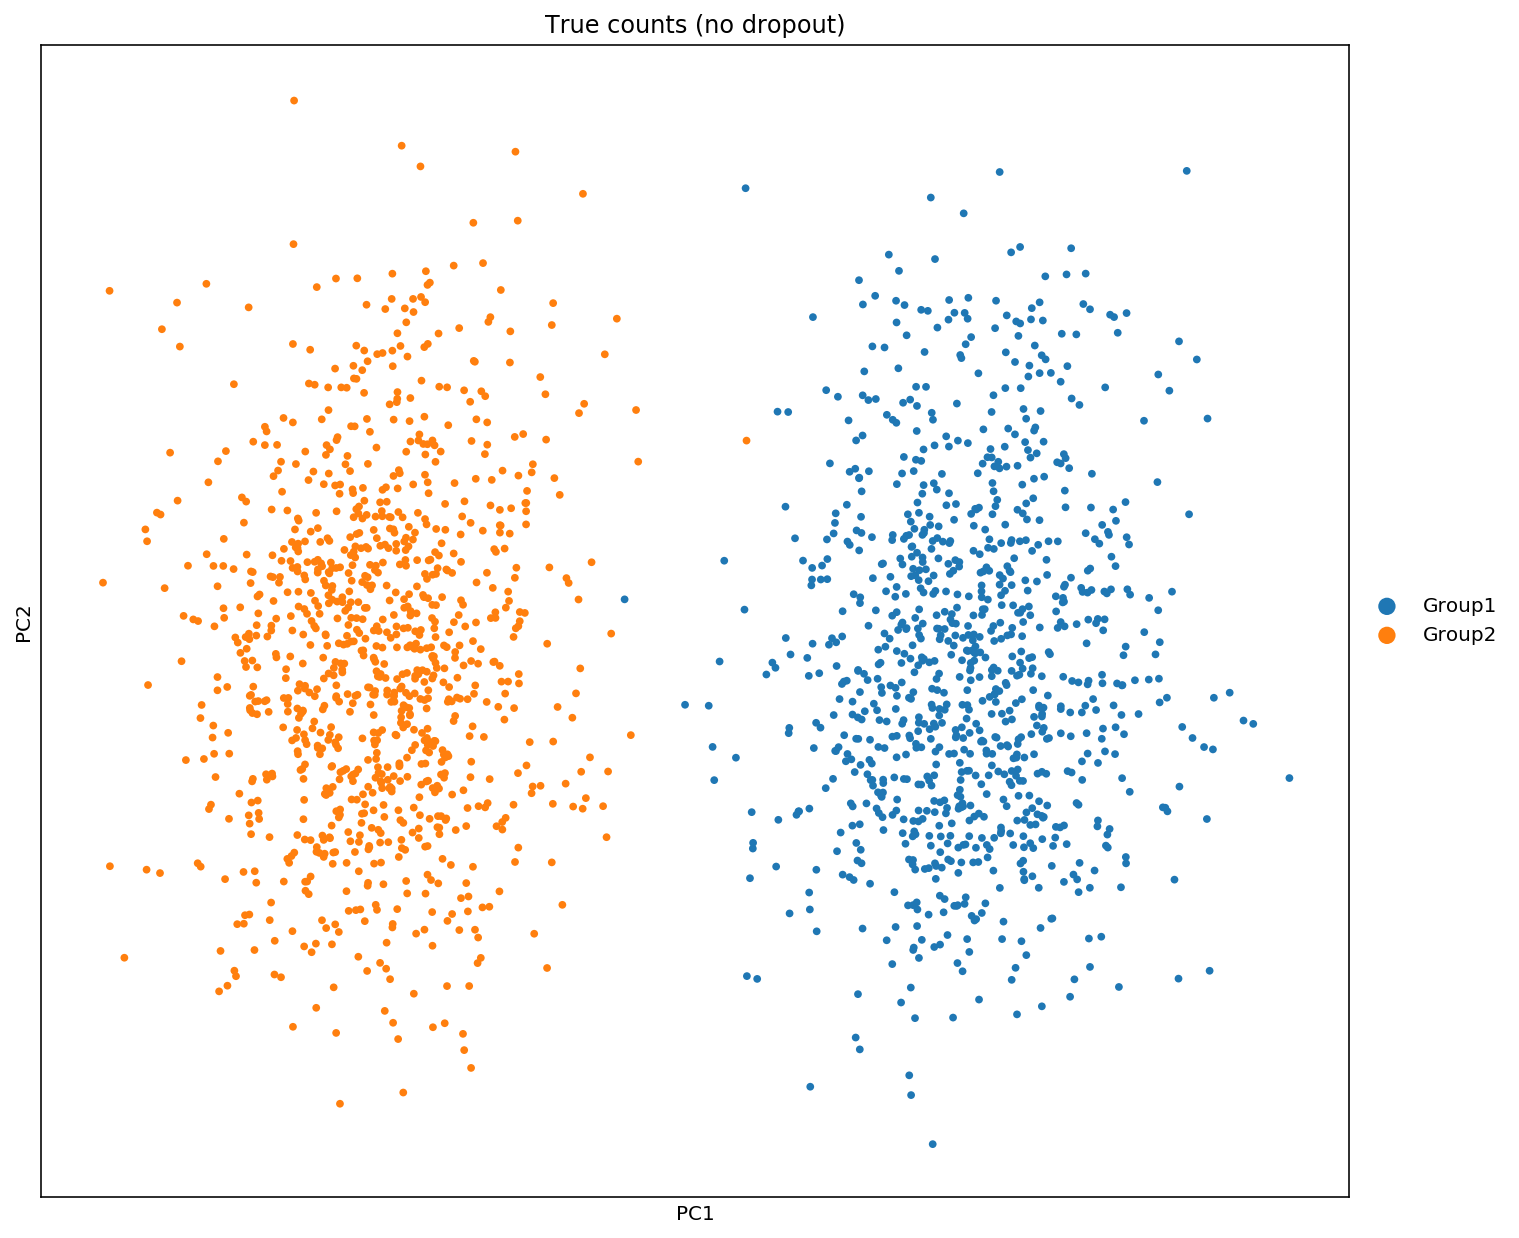

In [63]:
sc.pl.pca_scatter(adata_true, color='Group', size=60, title='True counts (no dropout)')

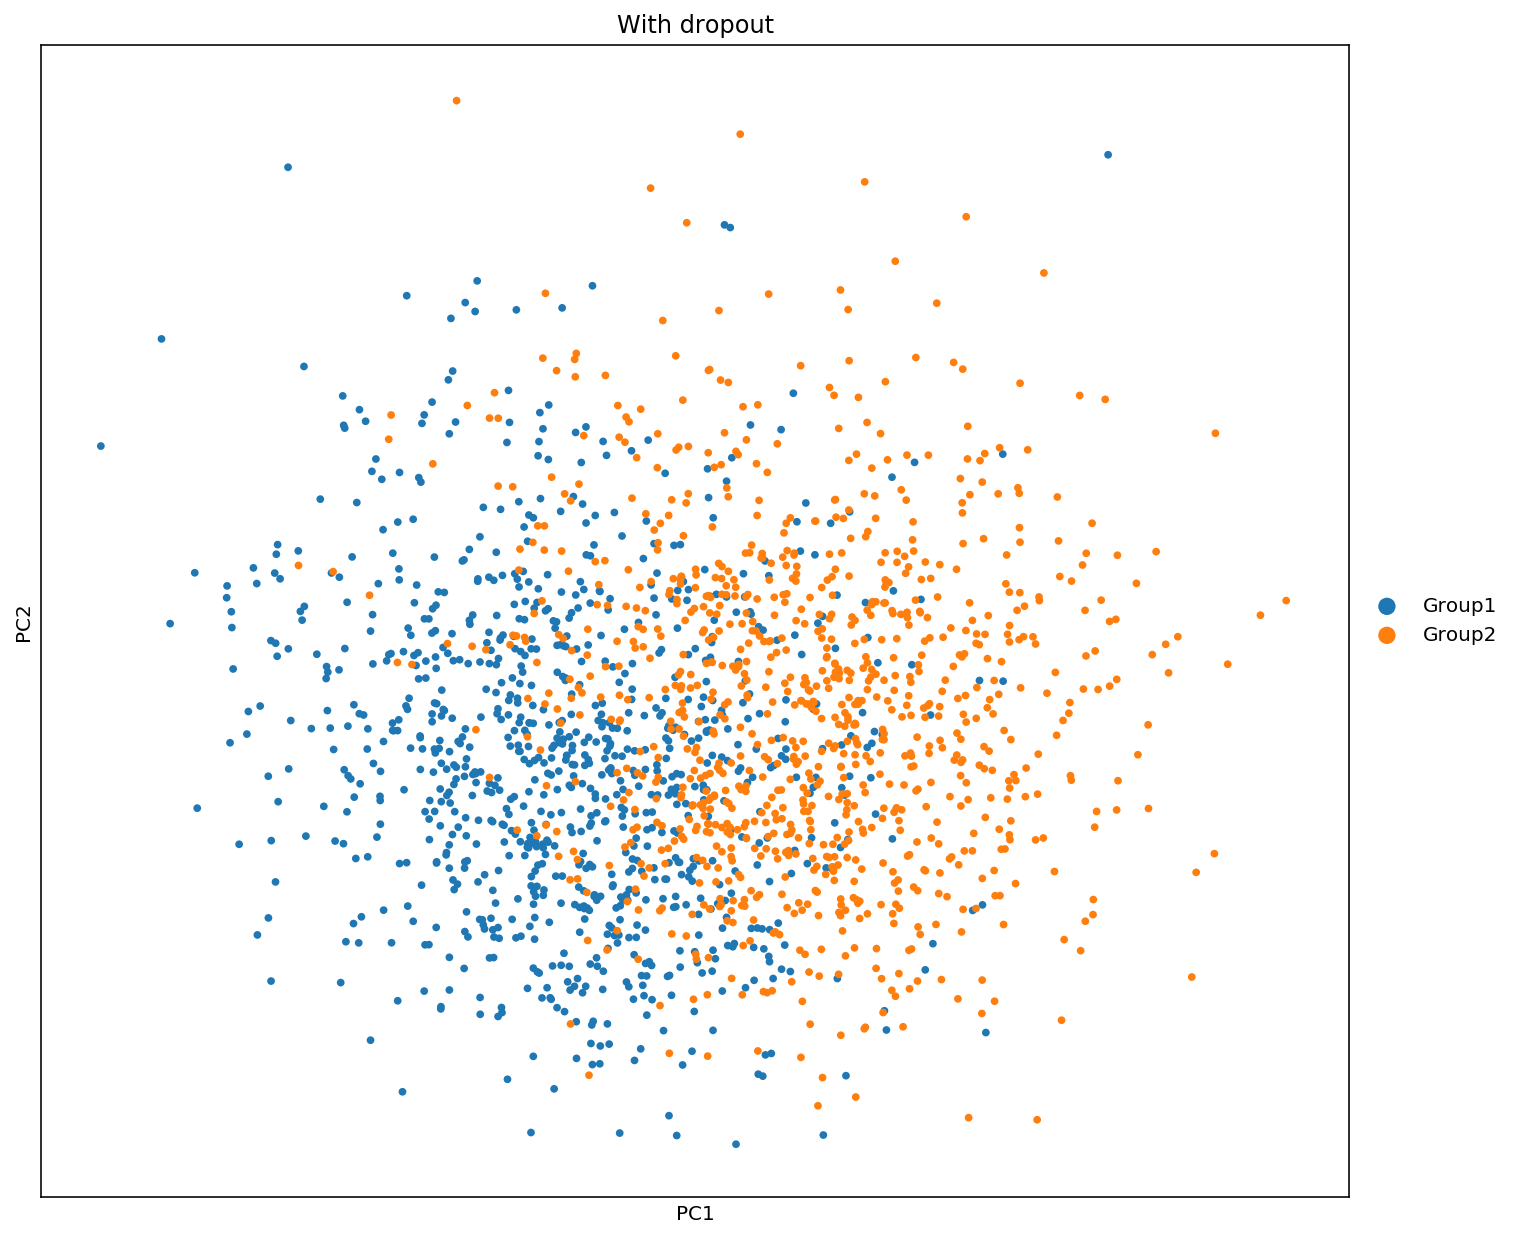

In [65]:
#sc.pp.pca(adata)
sc.pl.pca_scatter(adata, color='Group', size=60, title='With dropout')

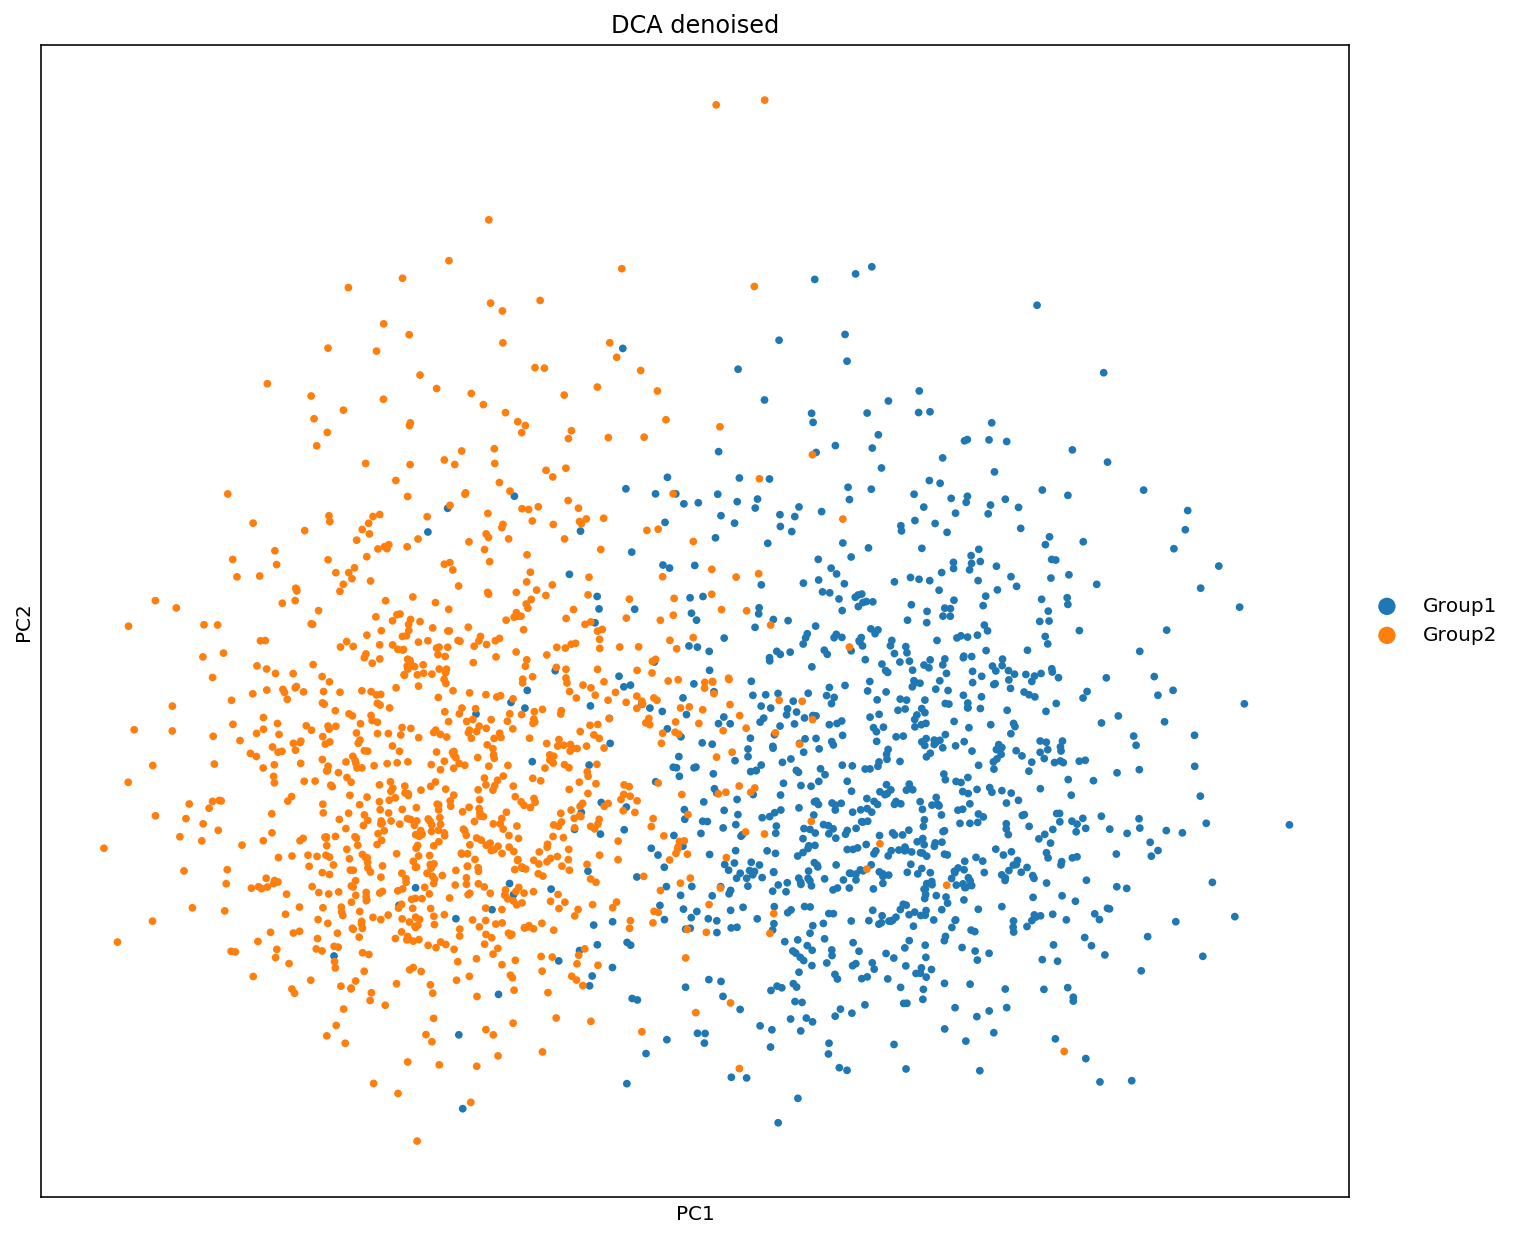

In [66]:
sc.pl.pca_scatter(adata_ae, color='Group', size=60, title='DCA denoised')

... storing 'Batch' as categorical
... storing 'Group' as categorical


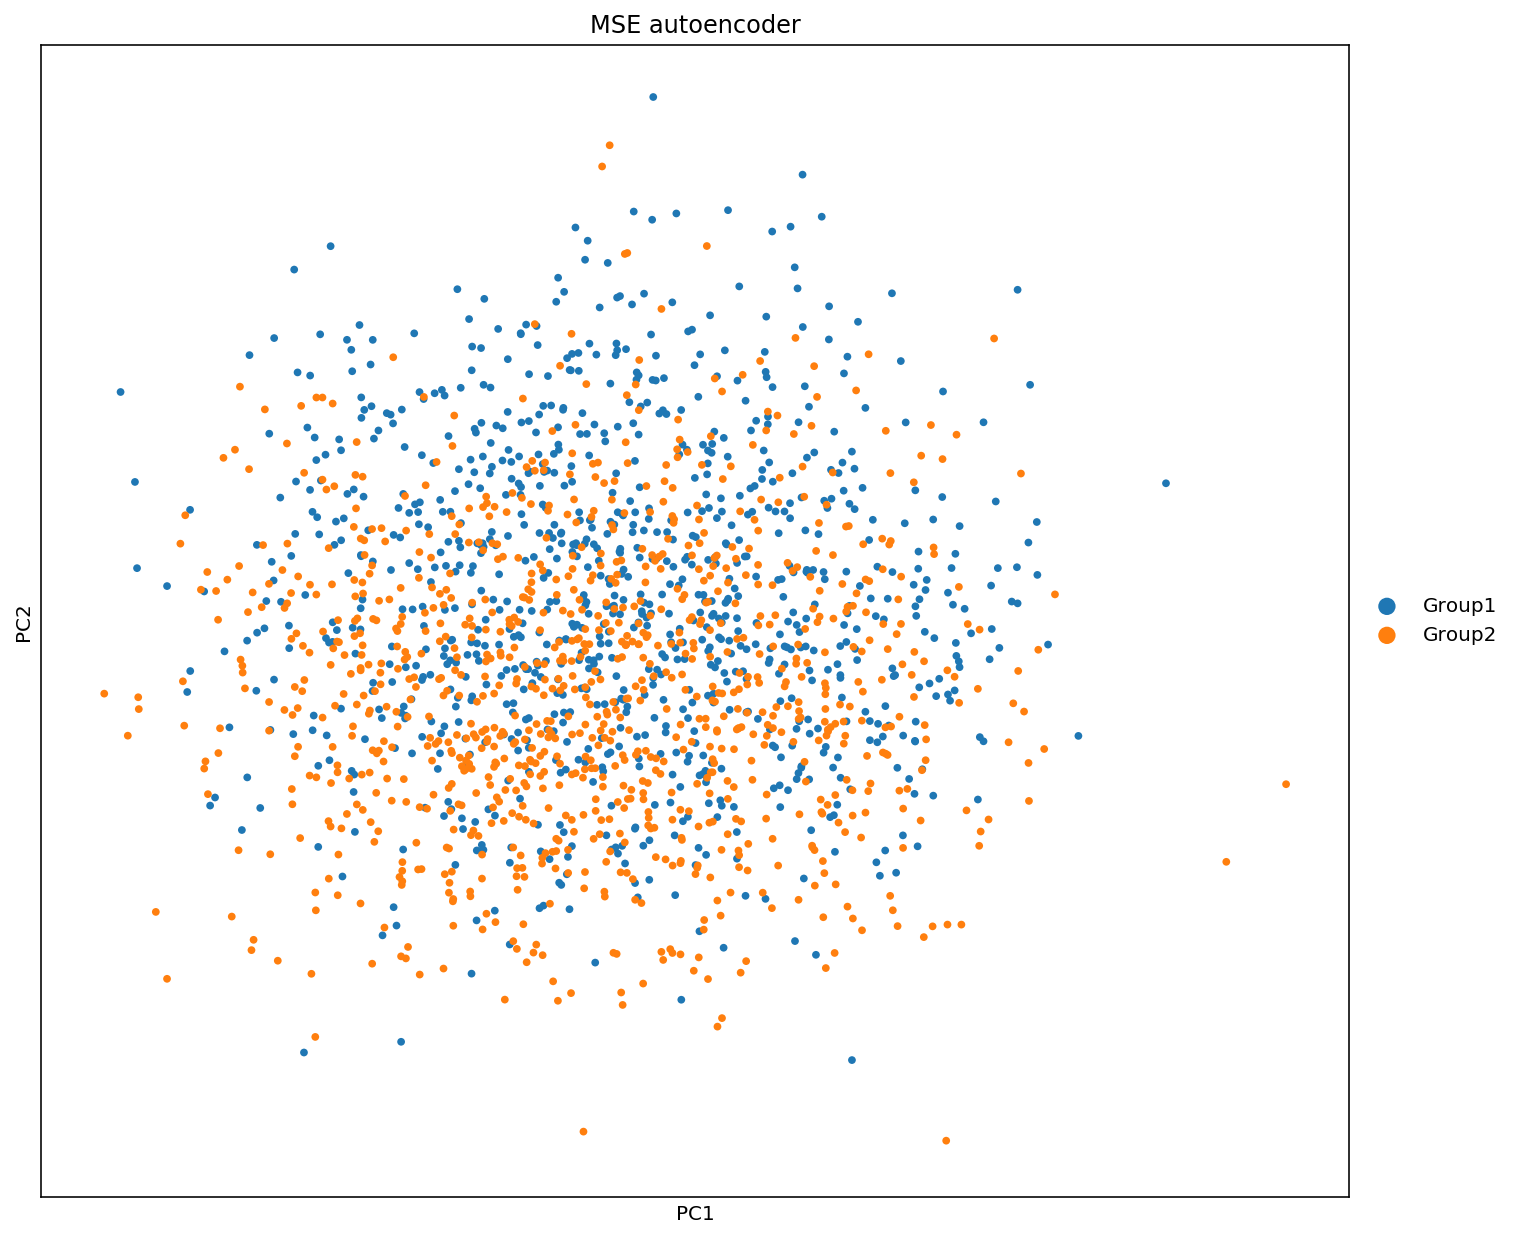

In [73]:
sc.pl.pca_scatter(adata_mse, color='Group', size=60, title='MSE autoencoder')

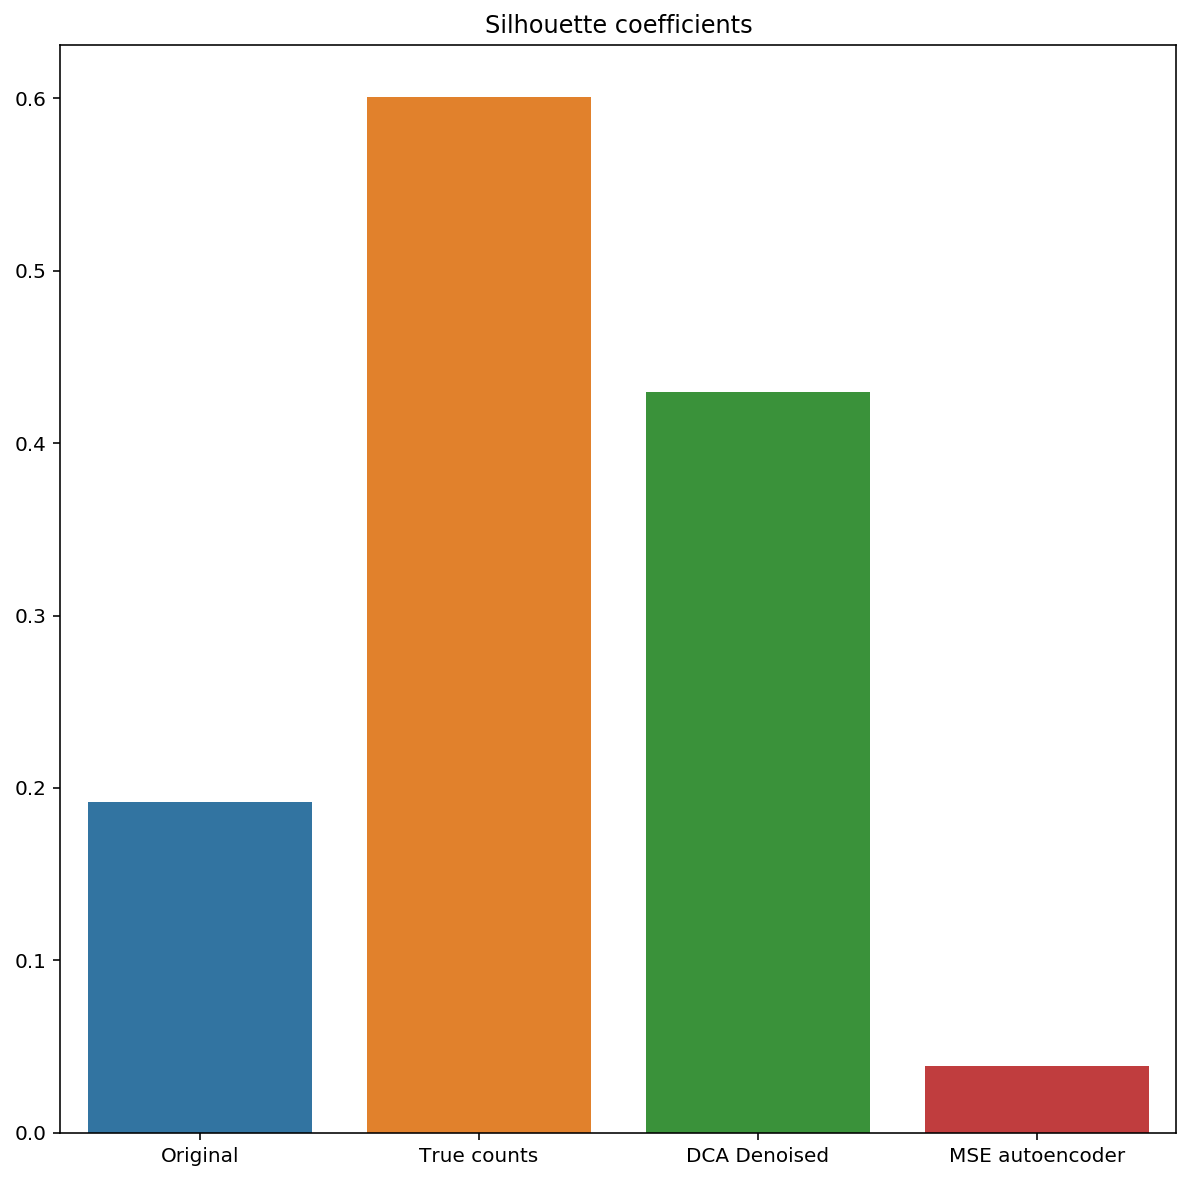

In [74]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm.X_pca[:, :2], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm.X_pca[:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm.X_pca[:, :2], adata_ae.obs.Group)
sil_mse = silhouette_score(adata_mse.obsm.X_pca[:, :2], adata_mse.obs.Group)

sns.barplot(x=['Original', 'True counts', 'DCA Denoised', 'MSE autoencoder'], 
            y=[sil_orig, sil_true, sil_ae, sil_mse])

plt.title('Silhouette coefficients');

In [168]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

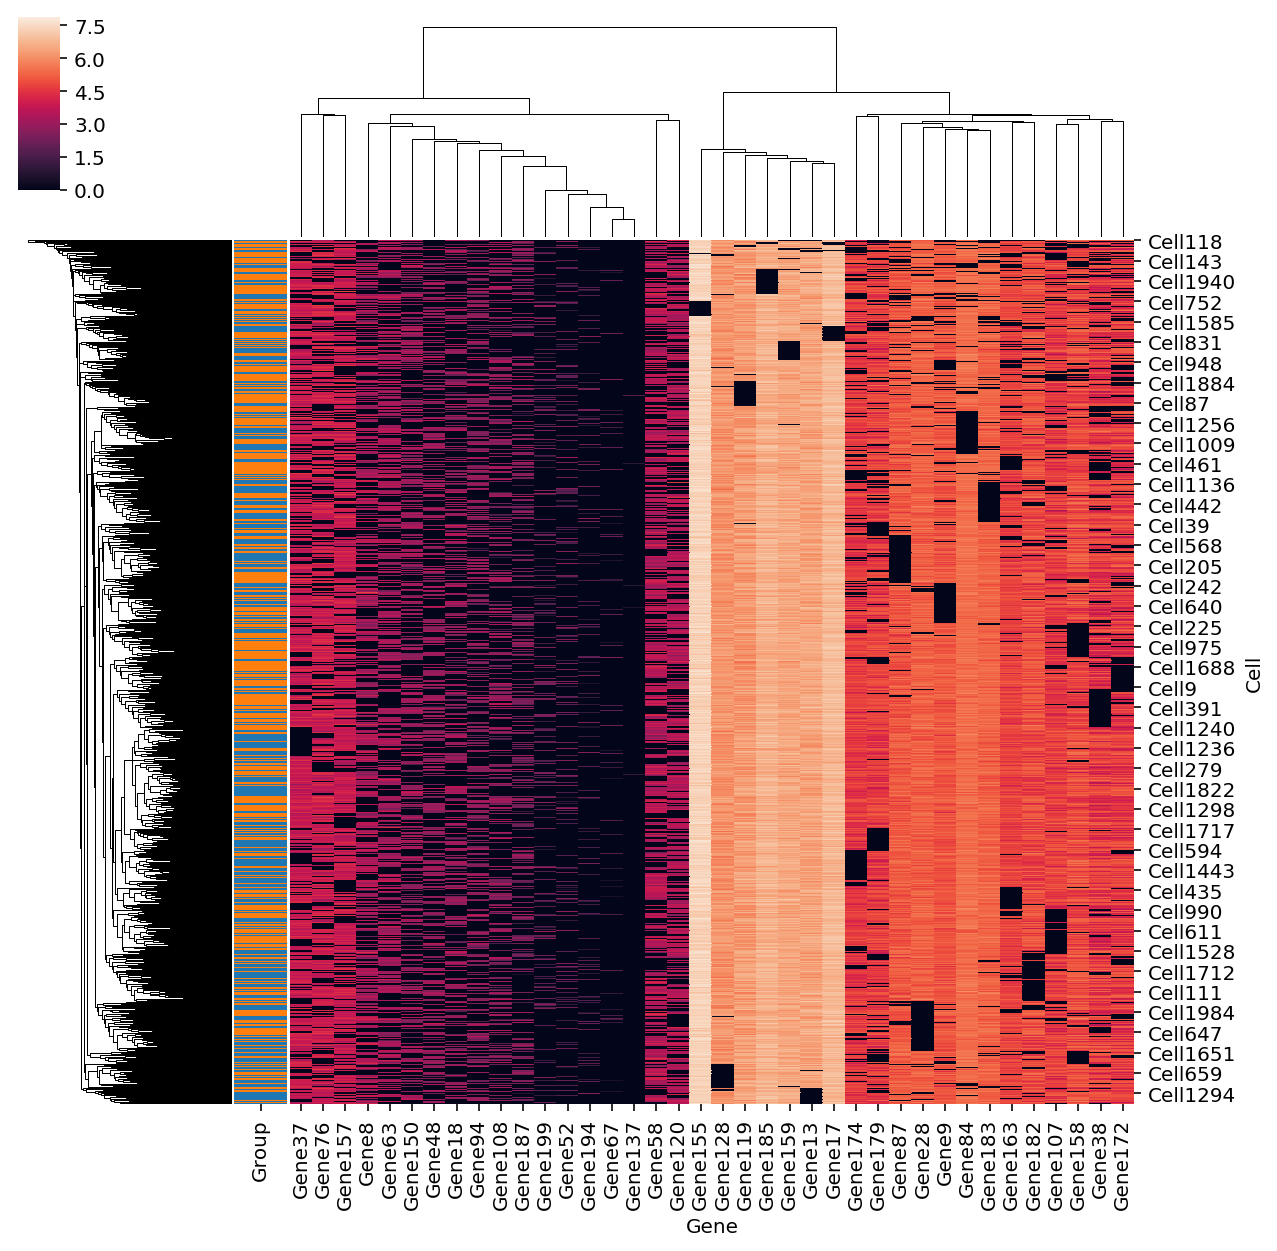

In [169]:
sc.pl.clustermap(adata[:, de_genes], 'Group')


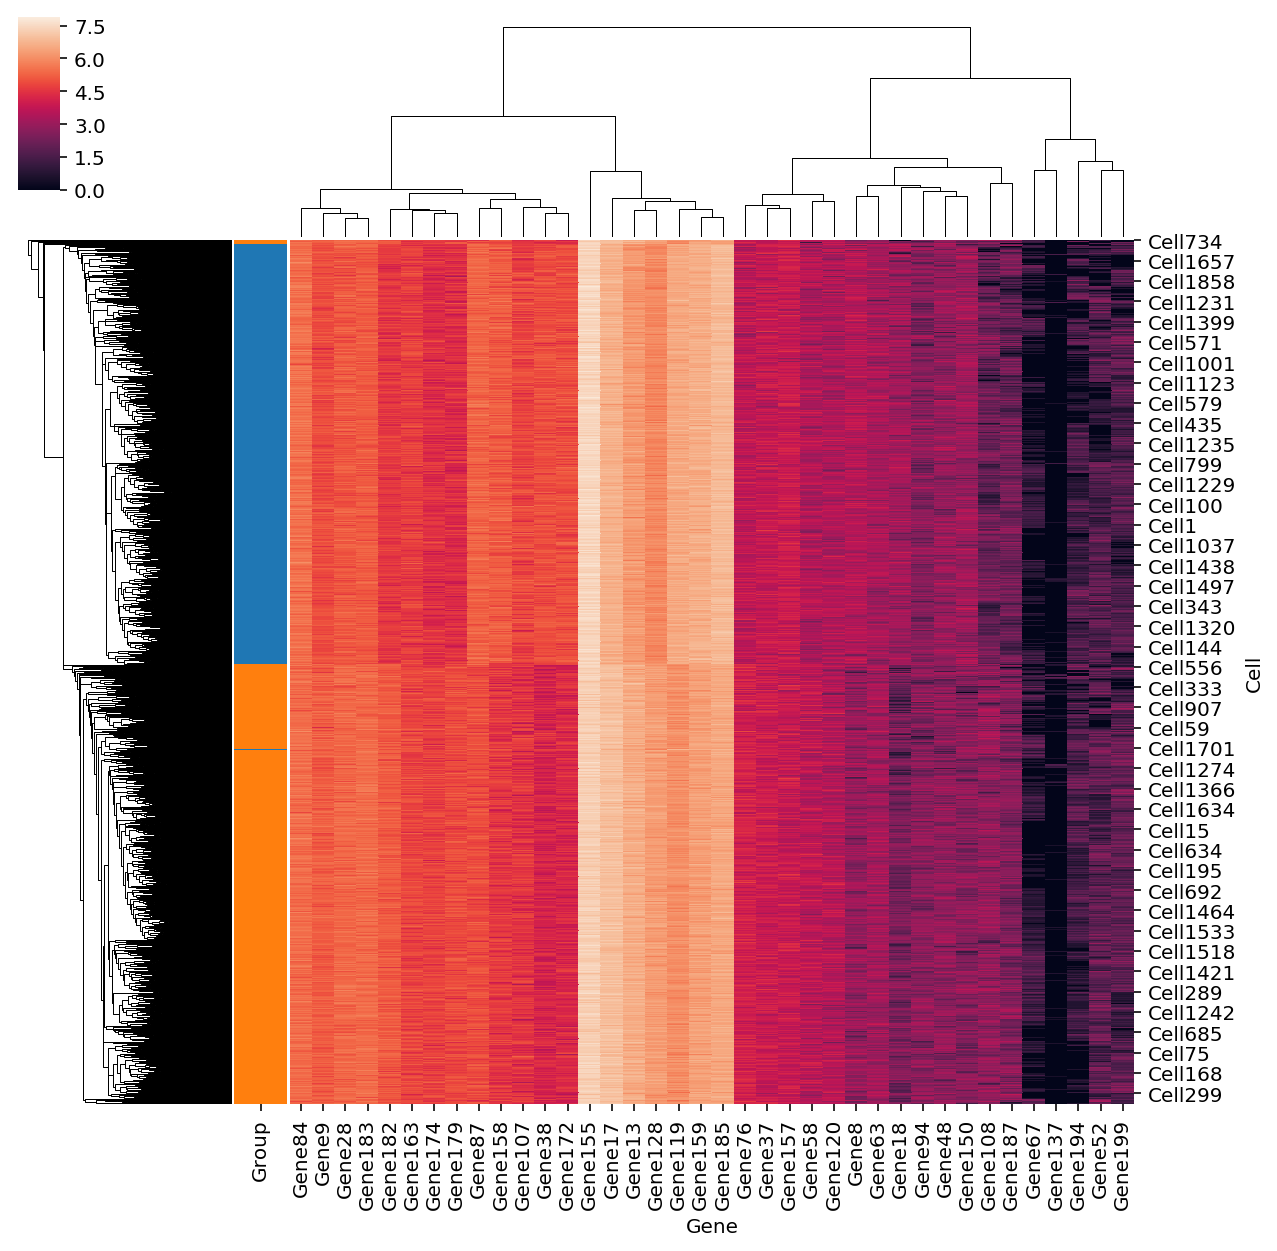

In [170]:
de_genes_true = (adata_true.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)
sc.pl.clustermap(adata_true[:, de_genes_true], 'Group')

In [57]:
adata.var.head()

Gene  BaseGeneMean  OutlierFactor  GeneMean  DEFacGroup1  DEFacGroup2  \
Gene                                                                            
Gene1  Gene1      0.485693            1.0  0.485693          1.0     1.000000   
Gene2  Gene2      1.212736            1.0  1.212736          1.0     1.369529   
Gene3  Gene3      0.433642            1.0  0.433642          1.0     1.078714   
Gene4  Gene4      0.561546            1.0  0.561546          1.0     1.000000   
Gene5  Gene5      1.968039            1.0  1.968039          1.0     1.000000   

       n_counts  
Gene             
Gene1   59810.0  
Gene2  176706.0  
Gene3   55613.0  
Gene4   69539.0  
Gene5  242882.0

In [49]:
adata_ae.var.describe()

BaseGeneMean  OutlierFactor    GeneMean  DEFacGroup1  DEFacGroup2  \
count    200.000000     200.000000  200.000000   200.000000   200.000000   
mean       2.177772       3.635771    4.931107     1.016473     1.040748   
std        2.601592      13.510396   14.361309     0.102088     0.190878   
min        0.000314       1.000000    0.000314     0.527350     0.709297   
25%        0.407350       1.000000    0.431965     1.000000     1.000000   
50%        1.061791       1.000000    1.209312     1.000000     1.000000   
75%        3.071454       1.000000    3.578280     1.000000     1.000000   
max       13.546658     129.082531  137.058633     1.820830     2.435435   

           n_counts  
count  2.000000e+02  
mean   6.108221e+05  
std    1.763281e+06  
min    4.600000e+01  
25%    5.509900e+04  
50%    1.569790e+05  
75%    4.663250e+05  
max    1.686951e+07

In [171]:
de_genes_ae = (adata_ae.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

In [172]:
sum(de_genes_ae)

38

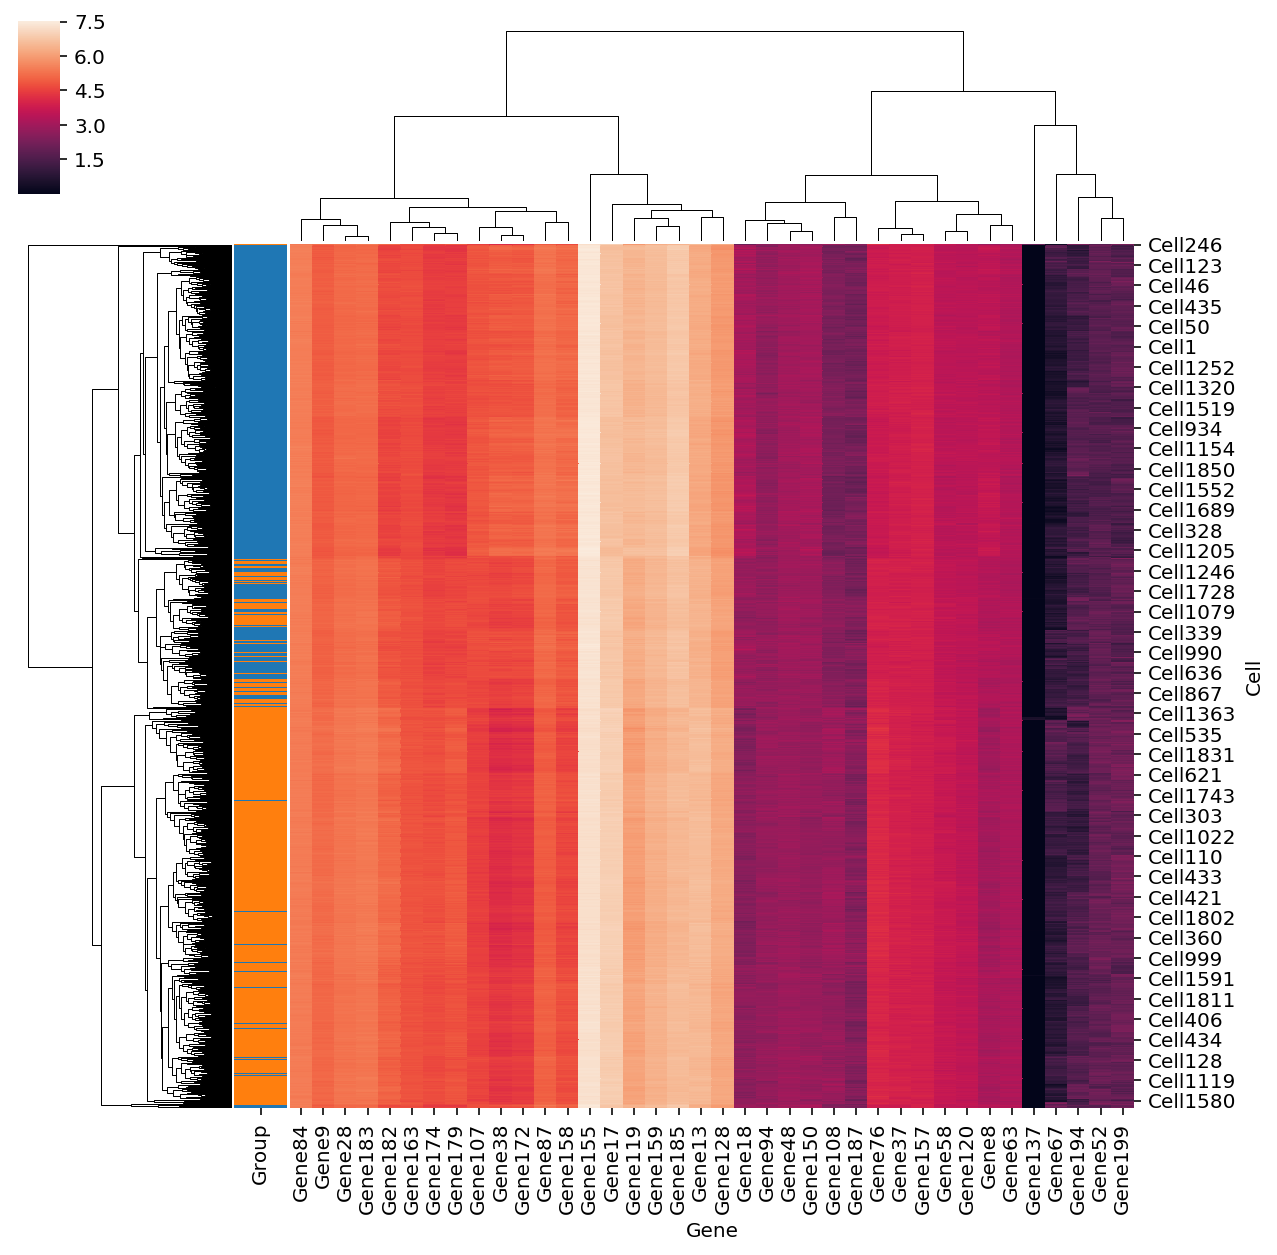

In [173]:
sc.pl.clustermap(adata_ae[:, de_genes_ae], 'Group', use_raw=False)

## Simulate six groups

In [76]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=2)
counts <- sim$counts
truecounts <- sim$truecounts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo


In [77]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene

In [78]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)


In [194]:
Series(list(set(adata.var.Gene) & set(adata_ae.var.Gene)))

NameError: name 'Series' is not defined

In [80]:
sc.tl.tsne(adata)

In [81]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true

AnnData object with n_obs × n_vars = 2000 × 200 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'

In [82]:
sc.pp.normalize_per_cell(adata_true)
sc.pp.log1p(adata_true)
sc.pp.pca(adata_true)


In [83]:
sc.tl.tsne(adata_true)

... storing 'Batch' as categorical
... storing 'Group' as categorical


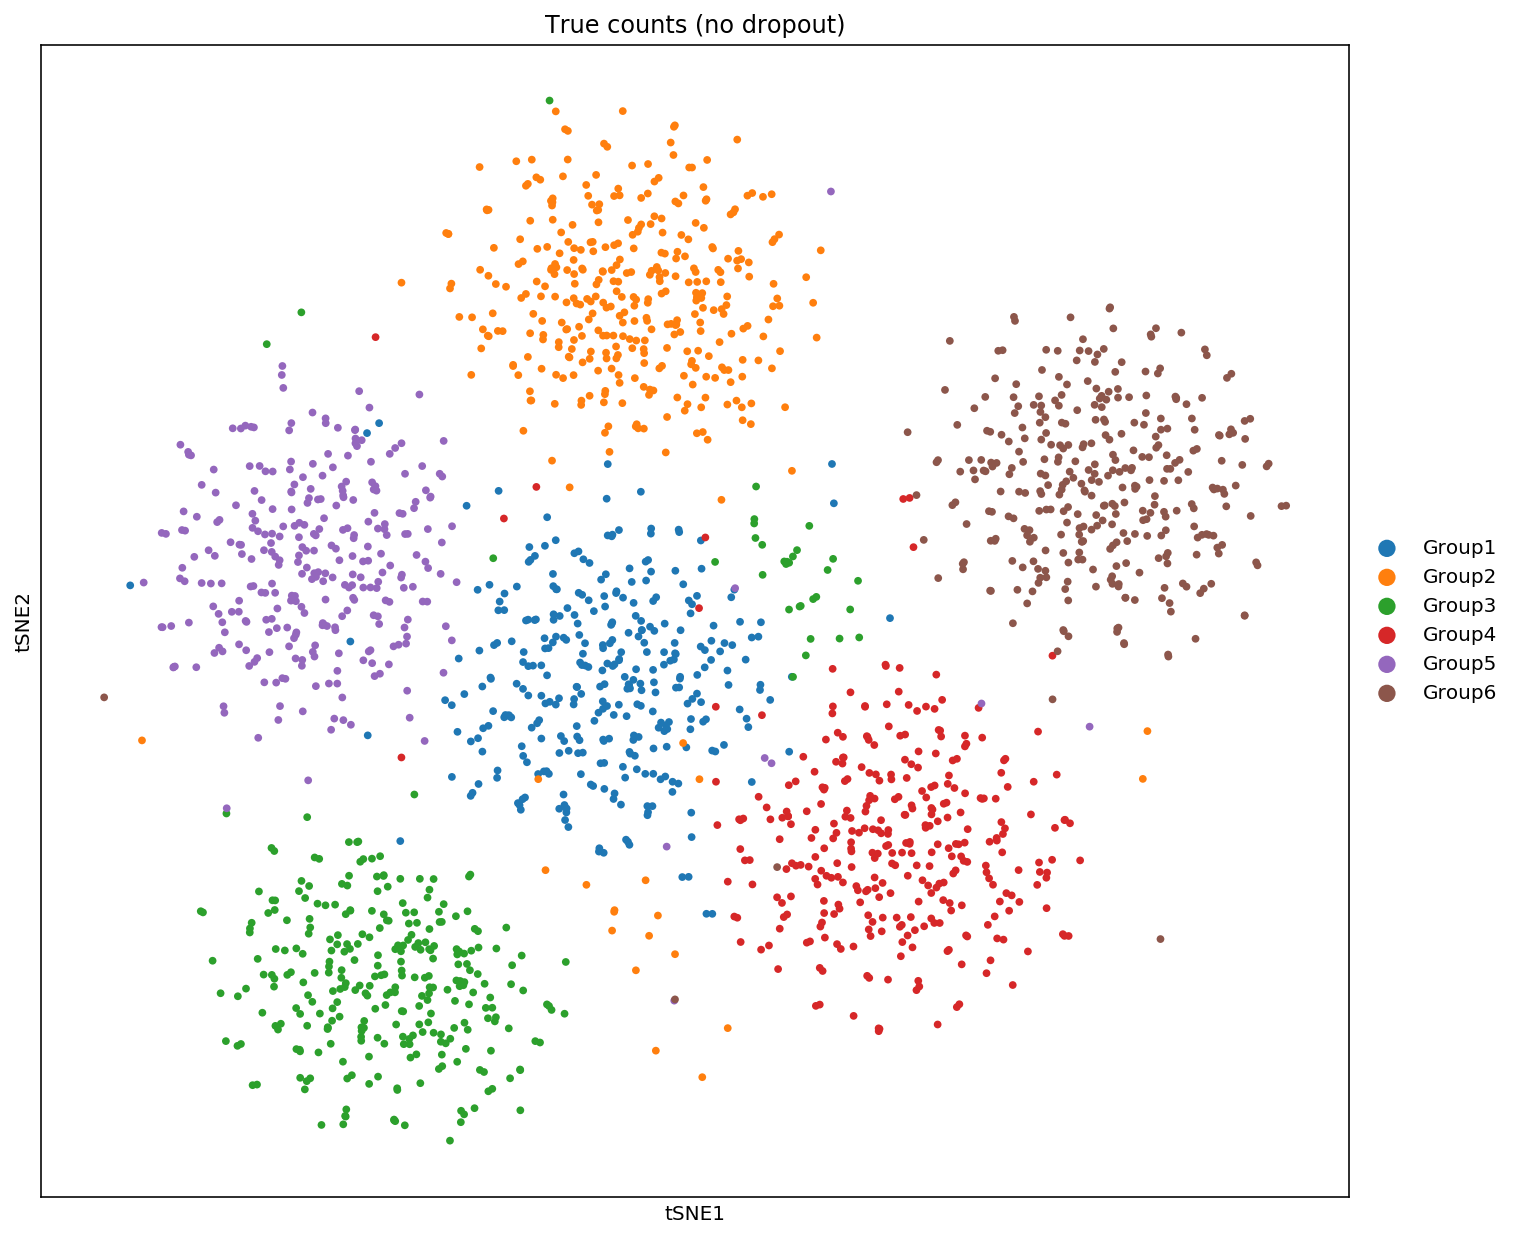

In [85]:
sc.pl.tsne(adata_true, color='Group', size=60, title='True counts (no dropout)')

... storing 'Batch' as categorical
... storing 'Group' as categorical


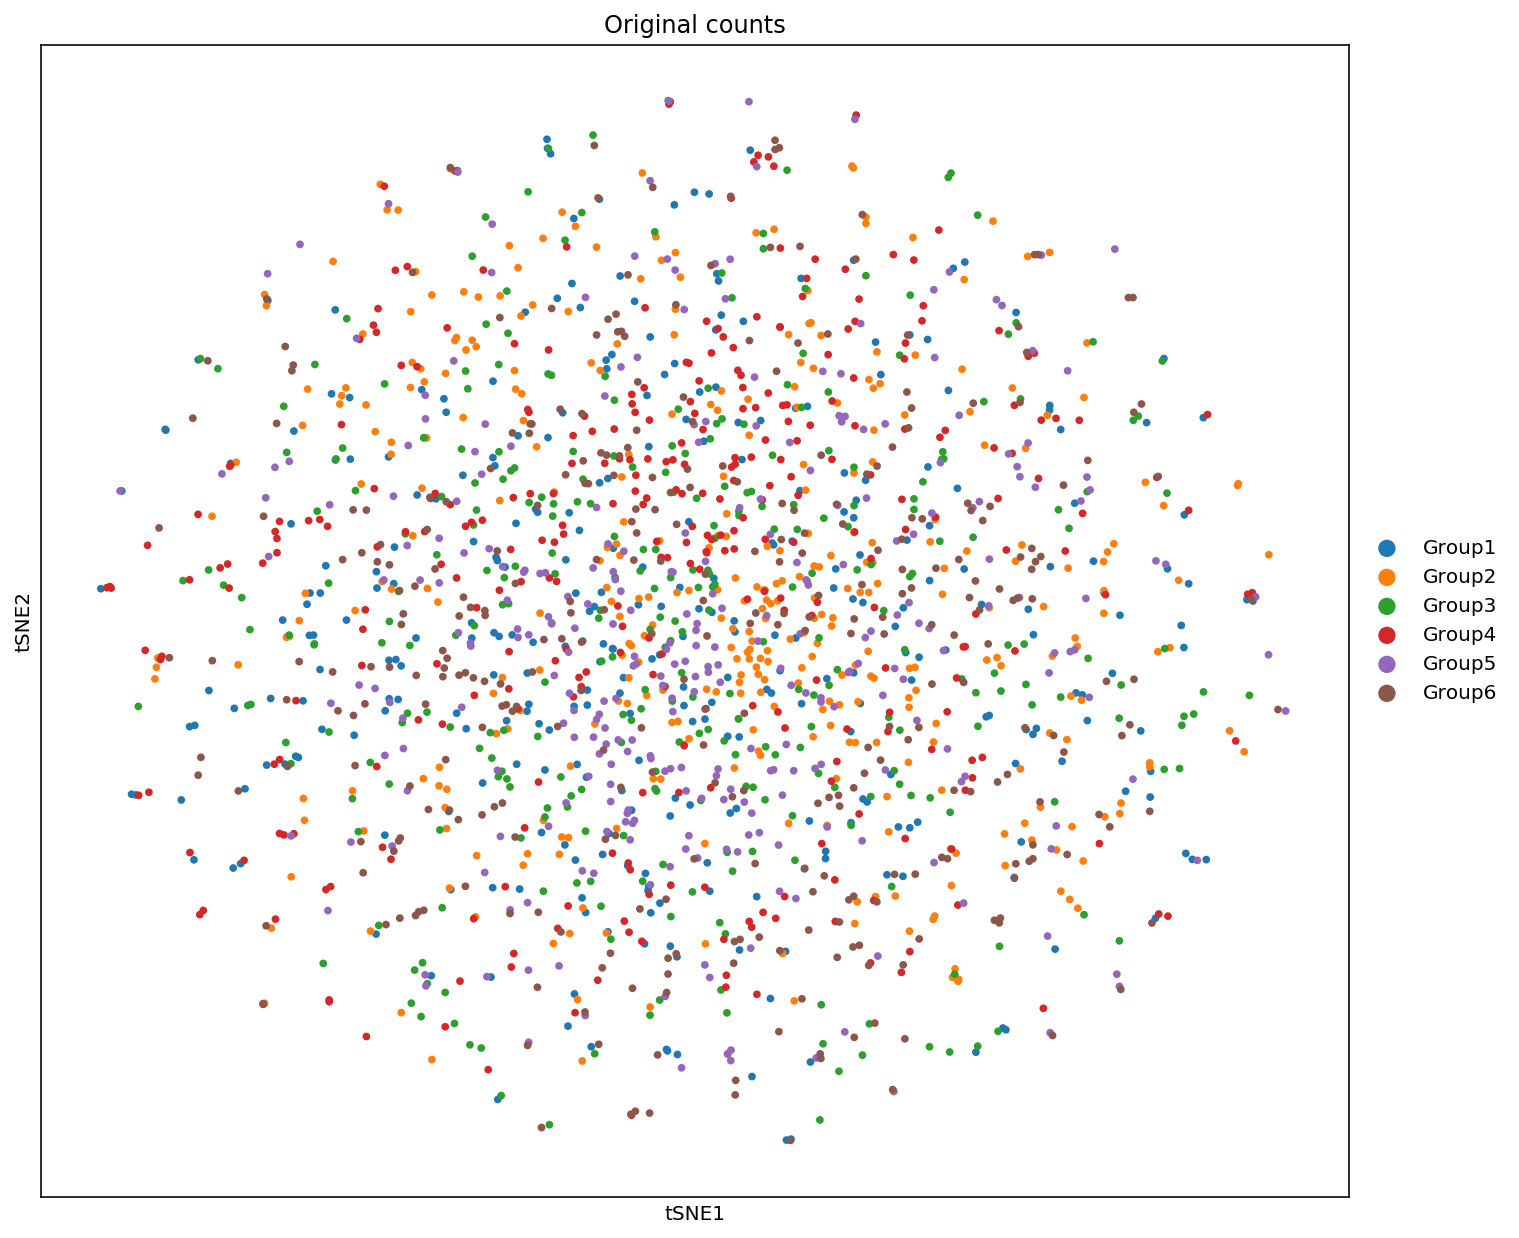

In [84]:
sc.pl.tsne(adata, color='Group', size=60, title='Original counts')

## Denoising simulated data with DCA

In [117]:
adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

In [120]:
adata_ae.n_vars

198

In [119]:
res_dca = dca.autoencode(adata_ae, training_kwds={'verbose': False})



### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.
Calculating low dimensional representations...
Calculating reconstructions...


In [90]:
res_dca

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts', 'DCA_split', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    obsm: 'X_dca', 'X_dca_mean', 'X_dca_hidden'

In [94]:
adata_ae.X = res_dca.obsm['X_dca']
sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.tl.tsne(adata_ae)

adata_ae

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts', 'DCA_split', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    obsm: 'X_dca', 'X_dca_mean', 'X_dca_hidden', 'X_pca', 'X_tsne'

... storing 'Batch' as categorical
... storing 'Group' as categorical


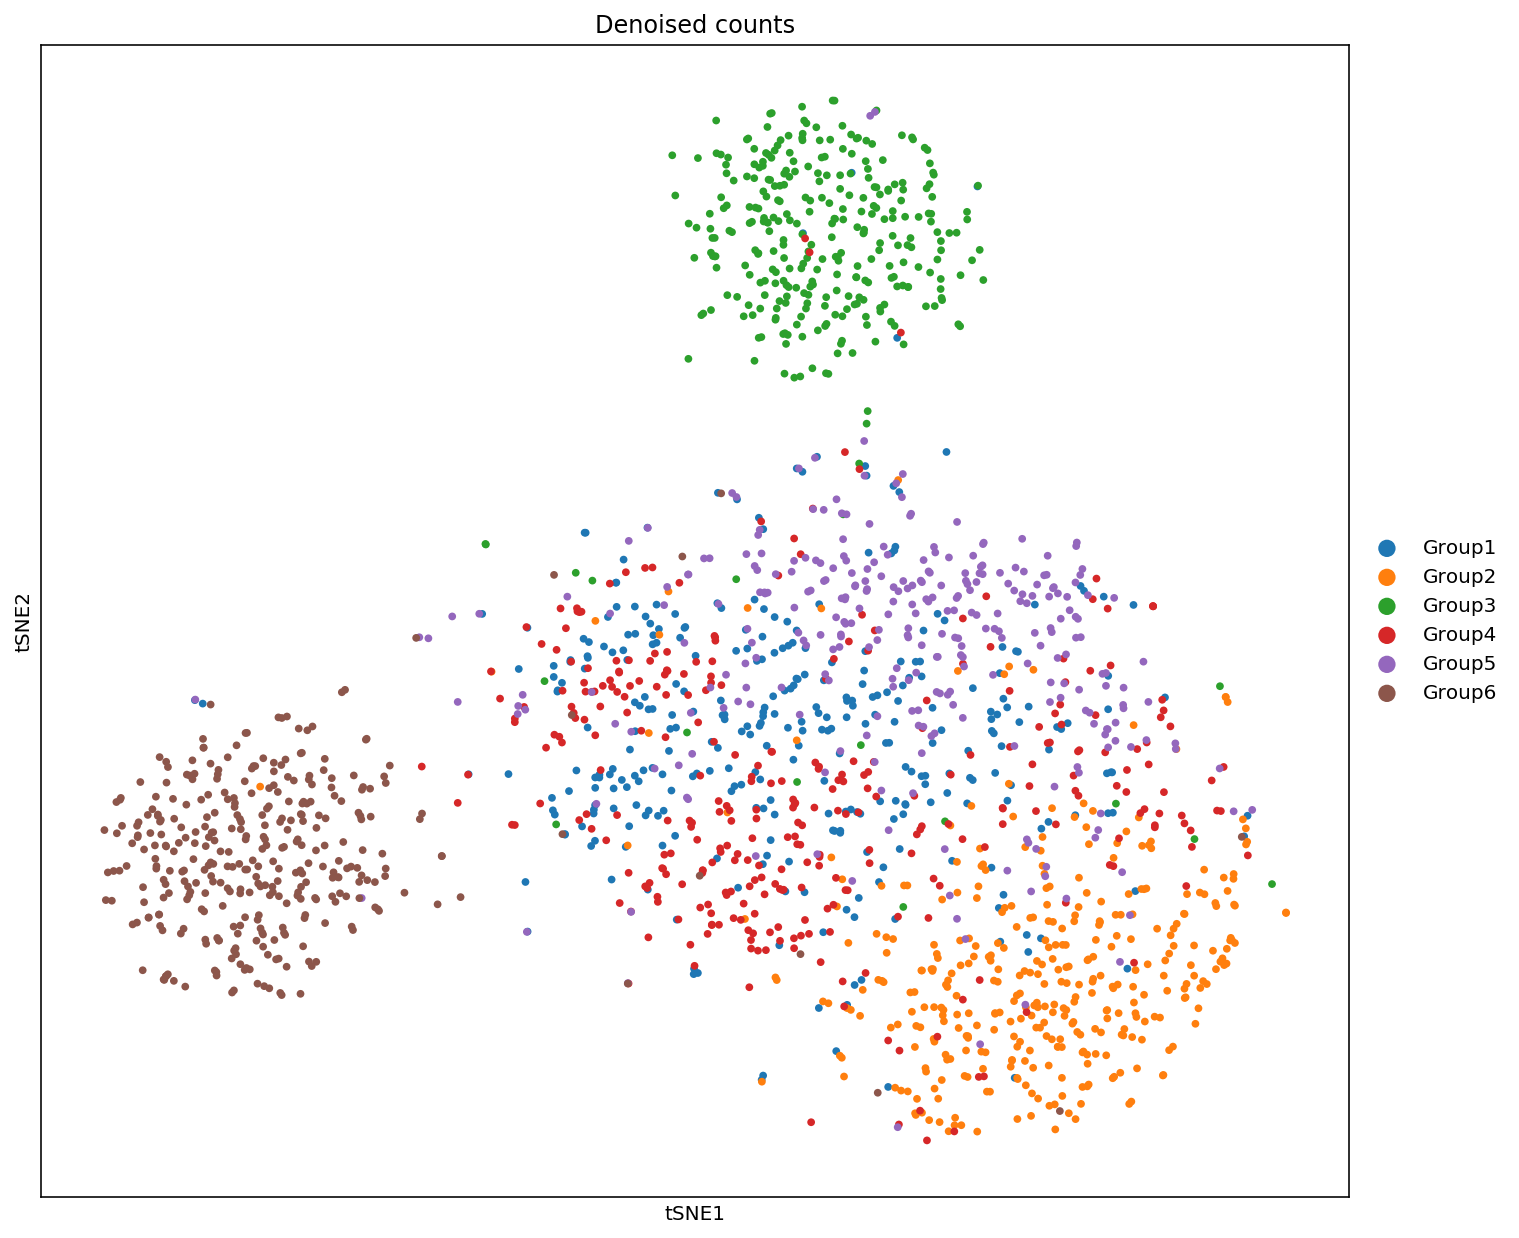

In [98]:
sc.pl.tsne(adata_ae, color='Group', size=60, title='Denoised counts')

## Denoising simulated data with poisson autoencoder

In [95]:
adata_mse = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_mse.obs_names = cellinfo.Cell
adata_mse.var_names = geneinfo.Gene

In [96]:
res_mse = dca.autoencode(adata_mse, ae_type='poisson', training_kwds={'verbose': False})

### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.
Calculating low dimensional representations...
Calculating reconstructions...


In [97]:
adata_mse.X = res_mse.obsm['X_dca']
sc.pp.normalize_per_cell(adata_mse)
sc.pp.log1p(adata_mse)
sc.tl.tsne(adata_mse)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'Batch' as categorical
... storing 'Group' as categorical


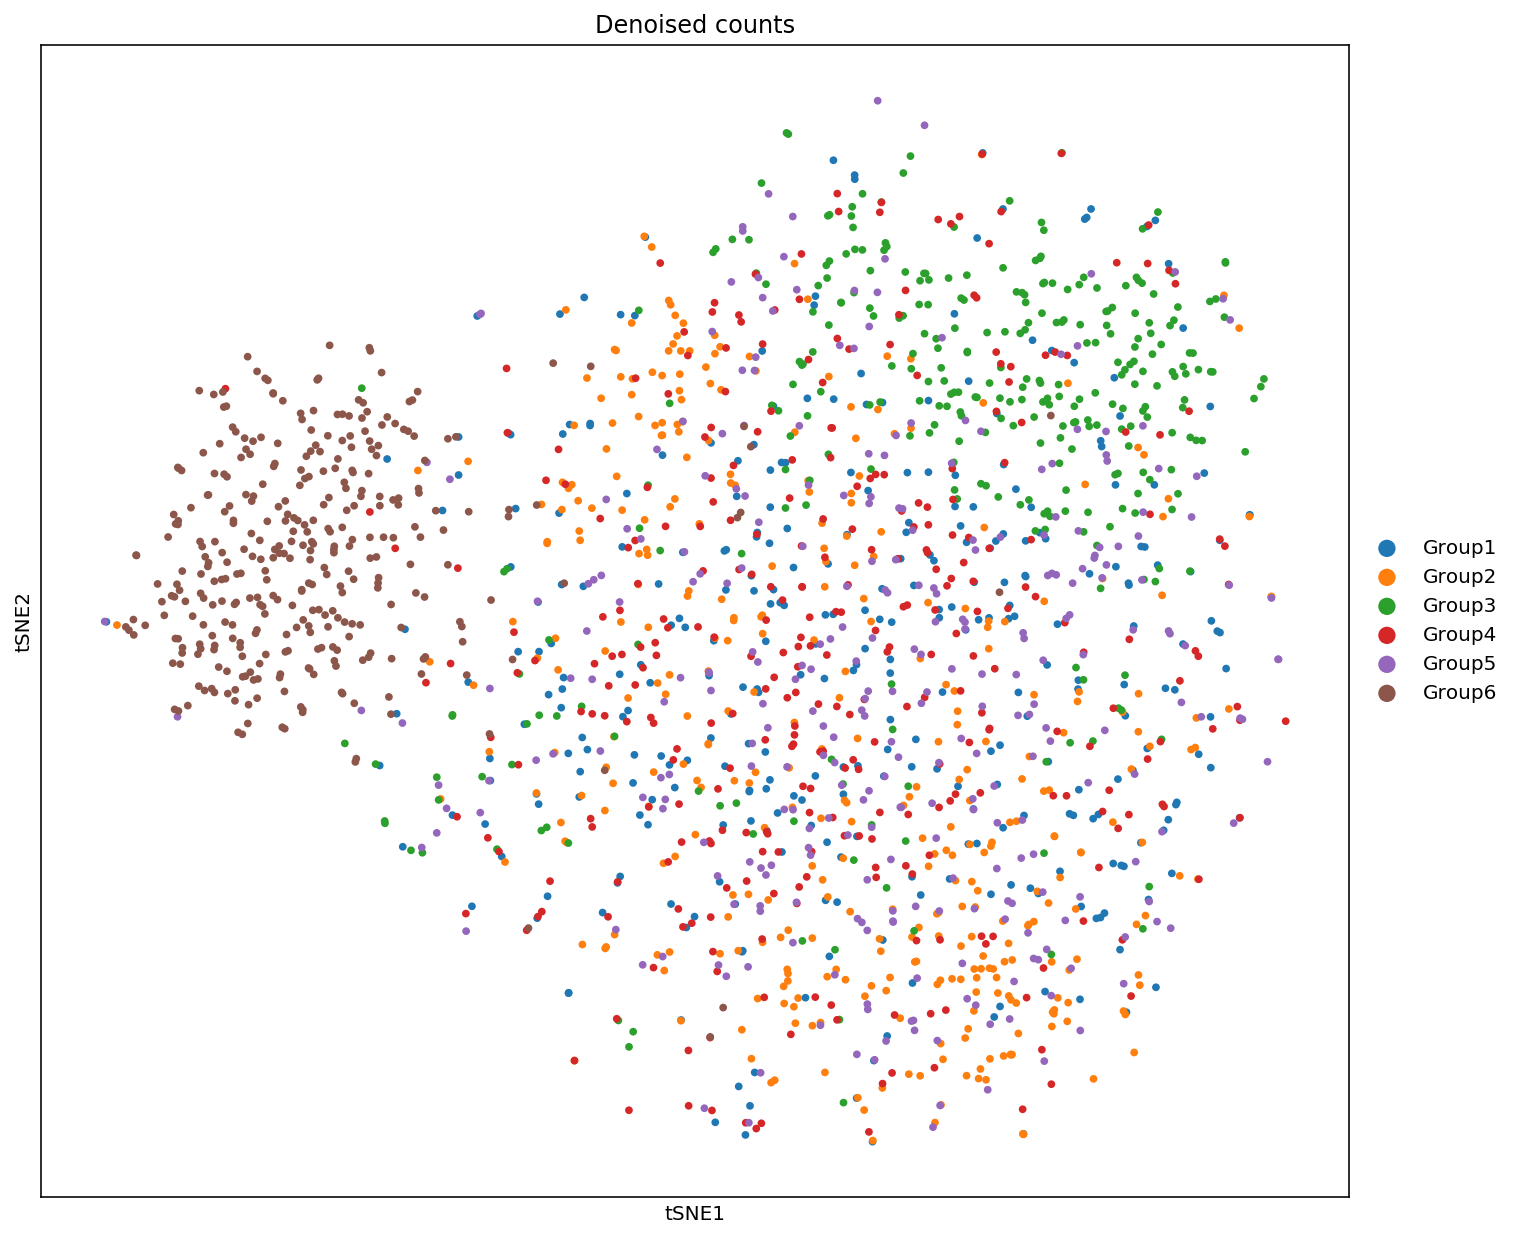

In [100]:
sc.pl.tsne(adata_mse, color='Group', size=60, title='Denoised counts')

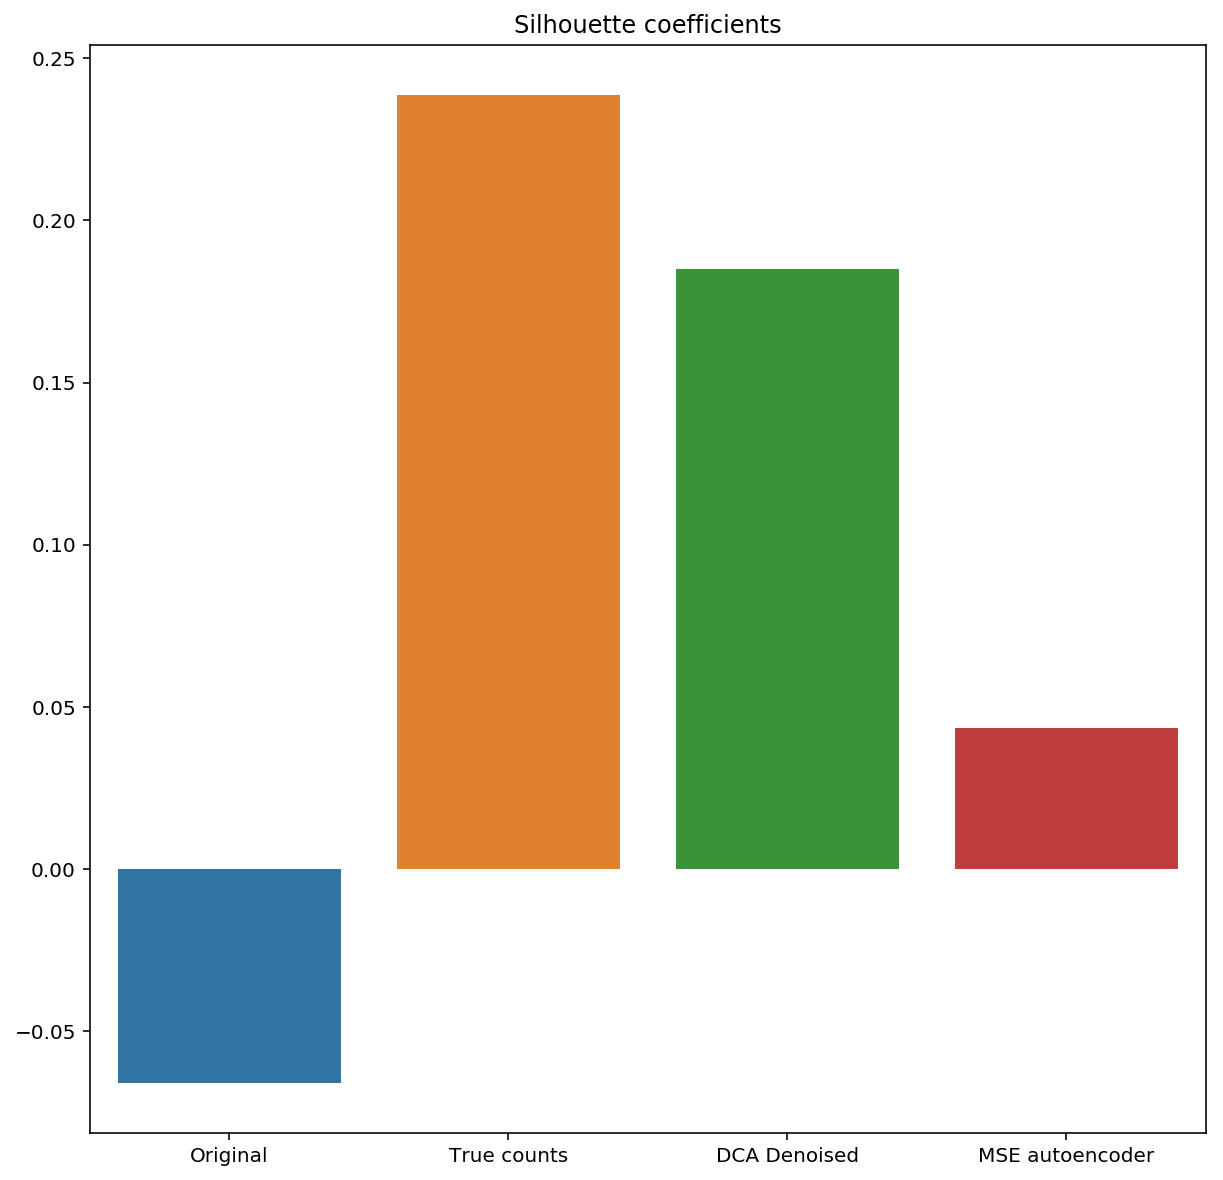

In [99]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm.X_pca[:, :2], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm.X_pca[:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm.X_pca[:, :2], adata_ae.obs.Group)
sil_mse = silhouette_score(adata_mse.obsm.X_pca[:, :2], adata_mse.obs.Group)

sns.barplot(x=['Original', 'True counts', 'DCA Denoised', 'MSE autoencoder'], 
            y=[sil_orig, sil_true, sil_ae, sil_mse])

plt.title('Silhouette coefficients');

In [17]:
adata

AnnData object with n_obs × n_vars = 2000 × 200 
    obs_keys = ['Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts']
    var_keys = ['Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6']
    uns_keys = ['Group_colors', 'pca']
    obsm_keys = ['X_pca', 'X_tsne']
    varm_keys = ['PCs']

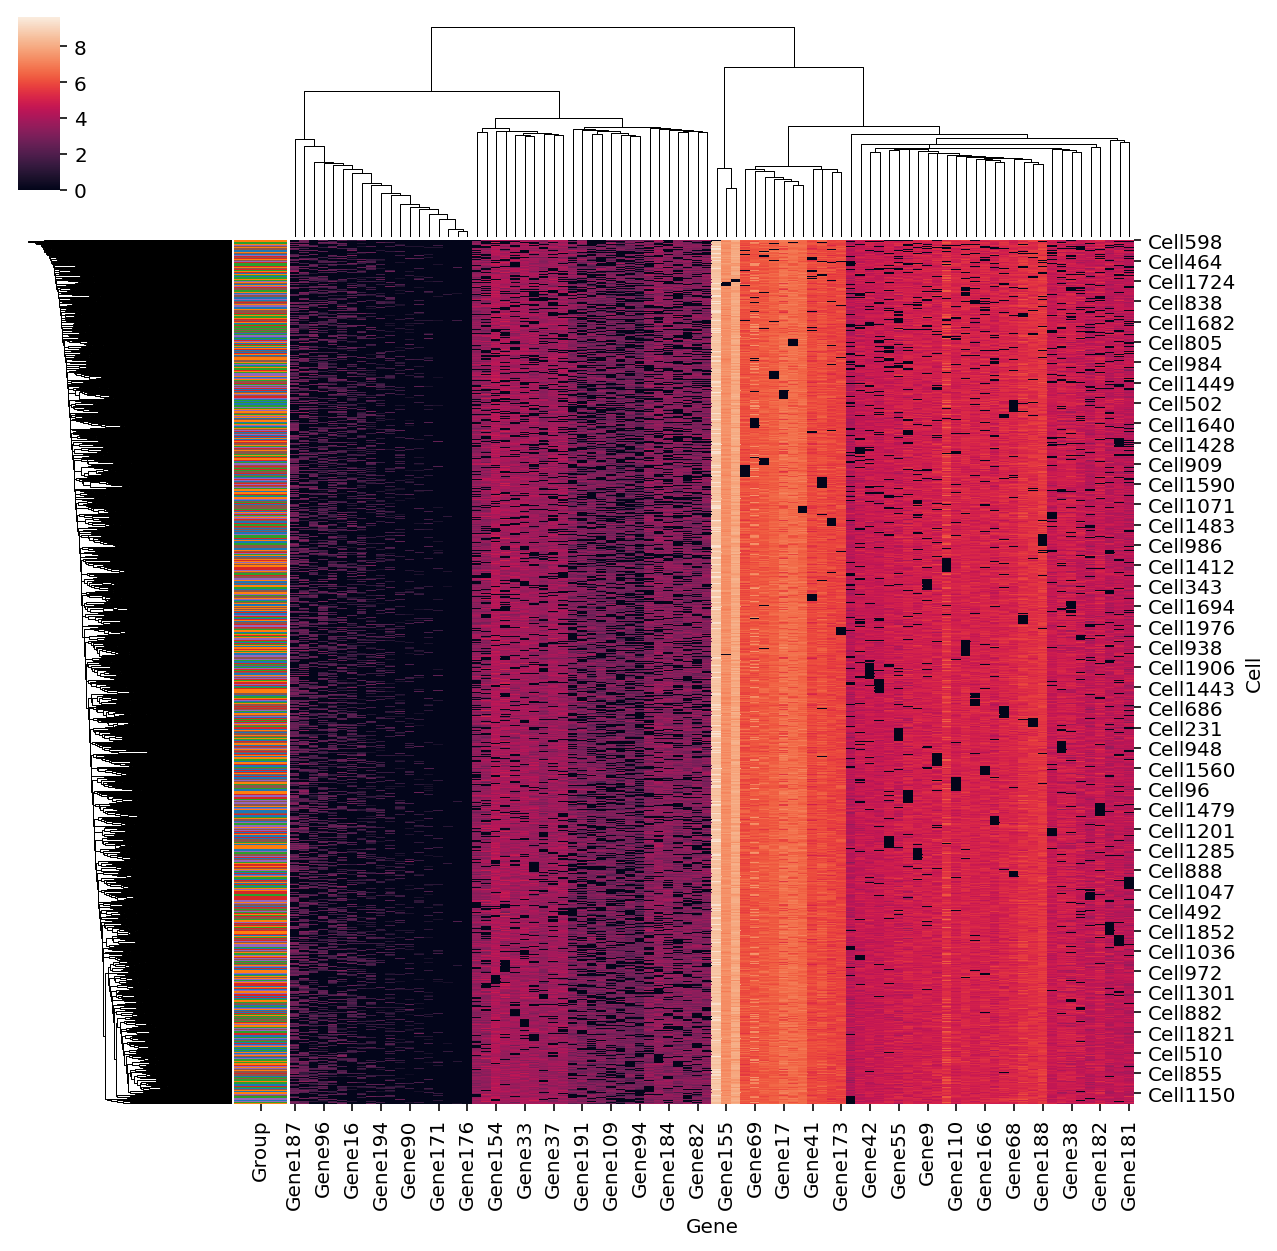

In [101]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

sc.pl.clustermap(adata[:, de_genes], 'Group')


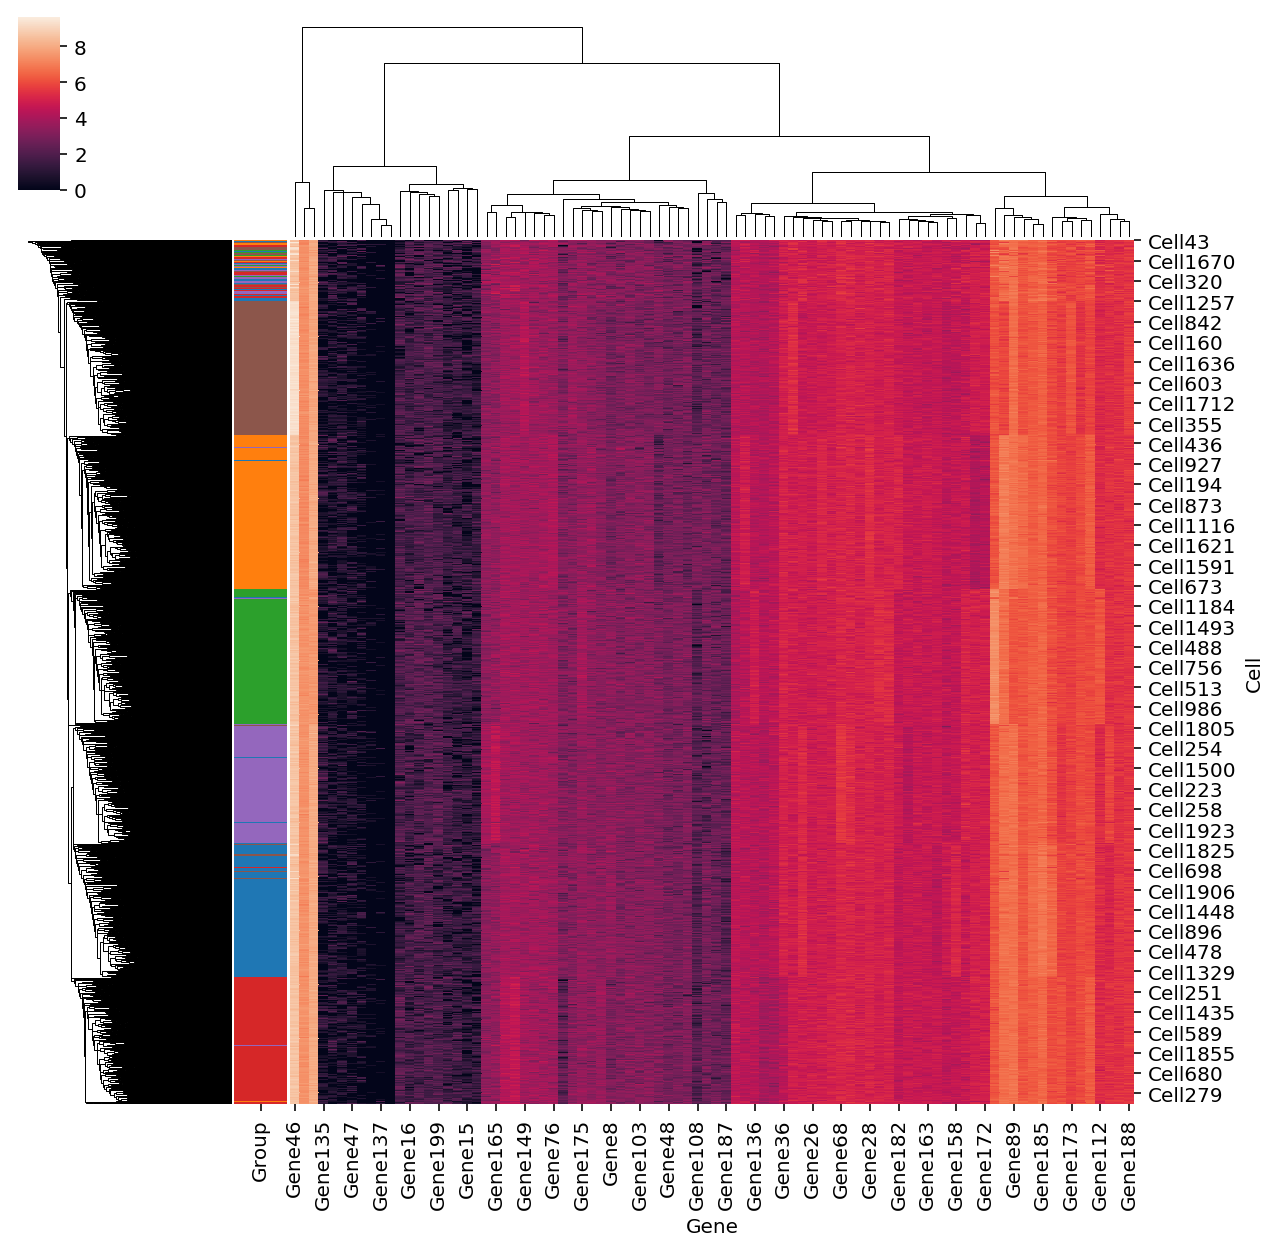

In [106]:
sc.pl.clustermap(adata_true[:, de_genes], 'Group')

In [103]:
sum(de_genes)

88

In [111]:
de_genes_ae = (adata_ae.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

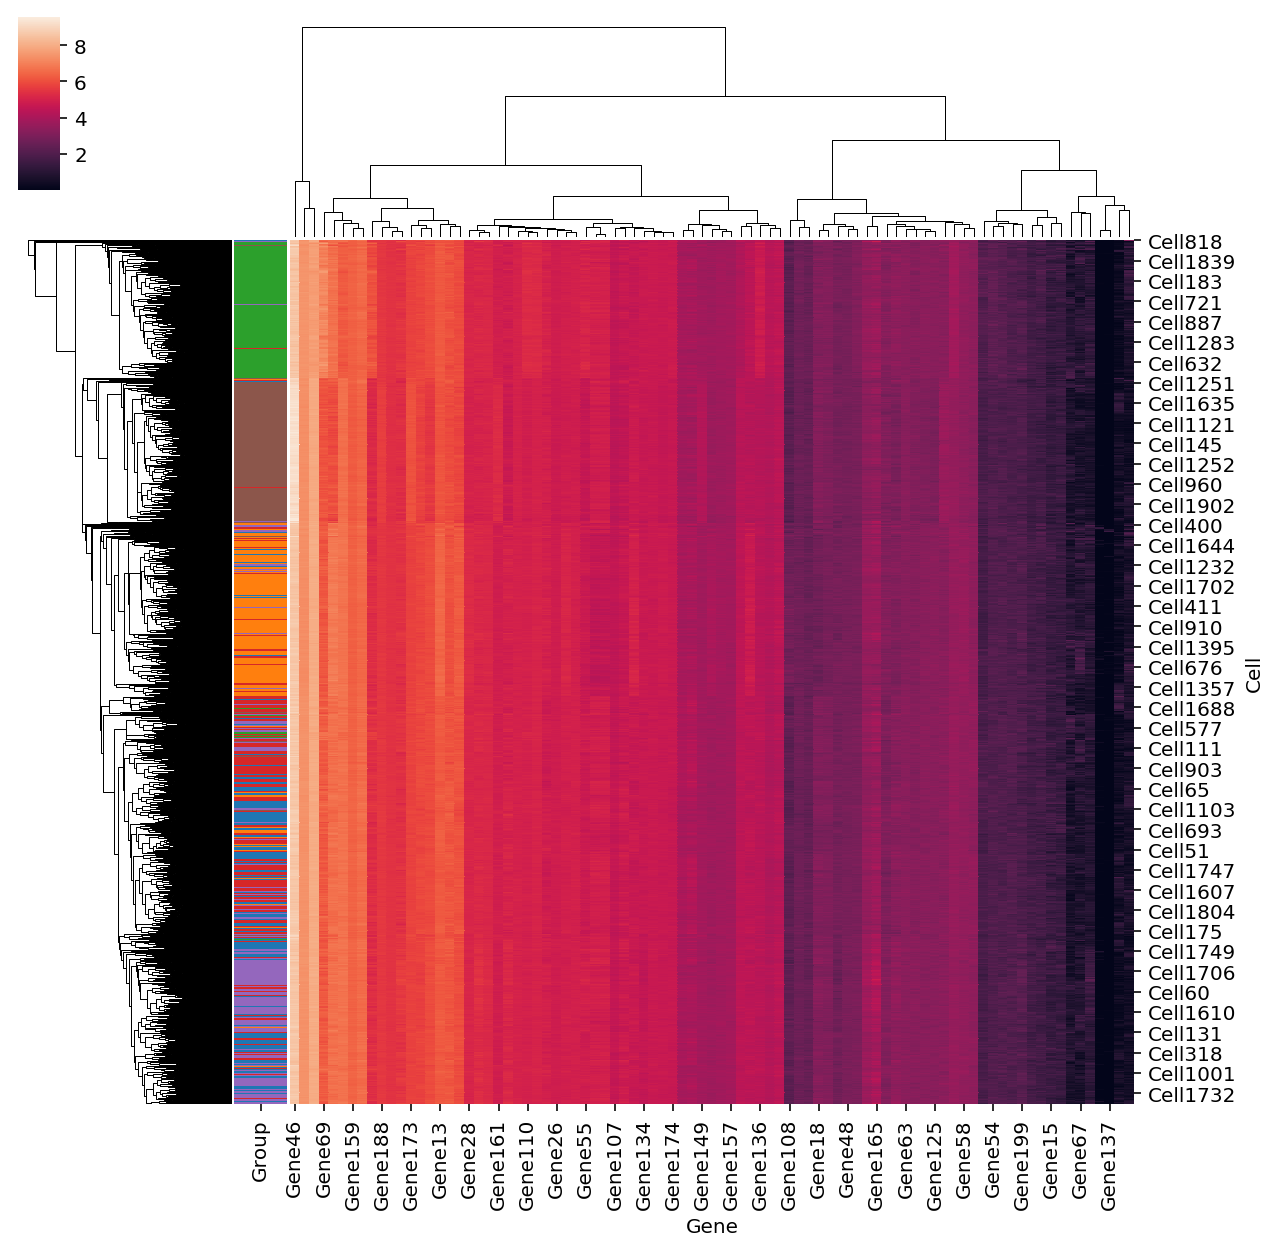

In [112]:
sc.pl.clustermap(adata_ae[:, de_genes_ae], 'Group', use_raw=False)

In [113]:
de_genes_mse = (adata_mse.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

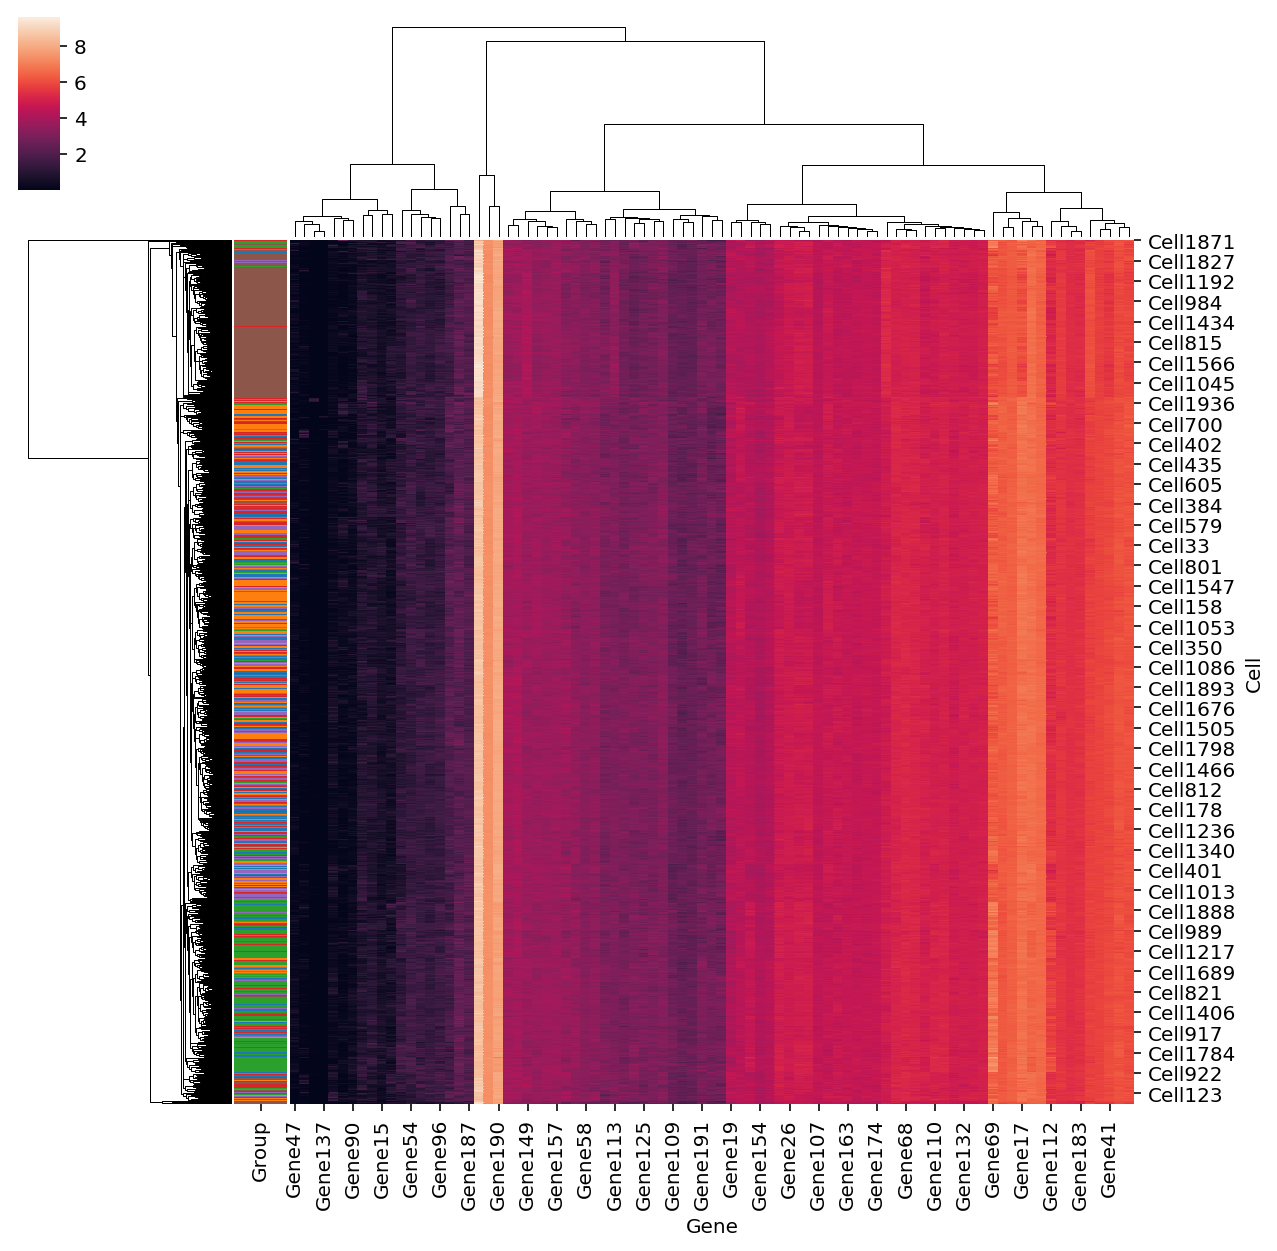

In [114]:
sc.pl.clustermap(adata_mse[:, de_genes_mse], 'Group', use_raw=False)